# Mobile Customer Churn

In this Portfolio task you will work with some (fake but realistic) data on Mobile Customer Churn.  Churn is where
a customer leaves the mobile provider.   The goal is to build a simple predictive model to predict churn from available features. 

The data was generated (by Hume Winzar at Macquarie) based on a real dataset provided by Optus.  The data is simulated but the column headings are the same. (Note that I'm not sure if all of the real relationships in this data are preserved so you need to be cautious in interpreting the results of your analysis here).  

The data is provided in file `MobileCustomerChurn.csv` and column headings are defined in a file `MobileChurnDataDictionary.csv` (store these in the `files` folder in your project).

Your high level goal in this notebook is to try to build and evaluate a __predictive model for churn__ - predict the value of the CHURN_IND field in the data from some of the other fields.  Note that the three `RECON` fields should not be used as they indicate whether the customer reconnected after having churned. 

__Note:__ you are not being evaluated on the _accuracy_ of the model but on the _process_ that you use to generate it.  You can use a simple model such as Logistic Regression for this task or try one of the more advanced methods covered in recent weeks.  Explore the data, build a model using a selection of features and then do some work on finding out which features provide the most accurate results.  

In [266]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import RFE
import warnings
warnings.filterwarnings("ignore")

In [282]:
churn = pd.read_csv("files/MobileCustomerChurn.csv", na_values=["NA", "#VALUE!"], index_col='INDEX')
churn.head()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,...,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH
INDEX,,,,,,,,,,,,,,,,,,,,,
1,1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,...,OFF-CONTRACT,24,SAMSUNG,1,61.40,COUNTRY,WA,NaN,NaN,NaN
2,2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,...,OFF-CONTRACT,24,APPLE,1,54.54,METRO,NSW,NaN,NaN,NaN
3,5,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,...,OFF-CONTRACT,12,APPLE,1,2.50,COUNTRY,WA,NaN,NaN,NaN
4,6,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,...,OFF-CONTRACT,24,APPLE,1,6.48,COUNTRY,VIC,NaN,NaN,NaN
5,8,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,...,OFF-CONTRACT,24,APPLE,1,100.22,METRO,NSW,NaN,NaN,NaN


In [283]:
dic=pd.read_csv("files/MobileChurnDataDictionary.csv")
dic

,column_Number,Variable_name,Description
0,1,CUST_ID,Unique customer identifier
1,2,ACCOUNT_TENURE,Account tenure in months based on last day of ...
2,3,ACCT_CNT_SERVICES,Total number of services under an account
3,4,AGE,Age of the account holder (derived on dob)
4,5,CFU,Customer facing unit derived based on owning c...
5,6,SERVICE_TENURE,Service tenure in months
6,7,PLAN_ACCESS_FEE,Monthly access fee payable for the plan exclud...
7,8,BYO_PLAN_STATUS,Whether the customer is on a BYO (bring your o...
8,9,PLAN_TENURE,Plan tenure in months
9,10,MONTHS_OF_CONTRACT_REMAINING,Contract tenure remaining based on months of c...


In [172]:
churn.corr()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,CHURN_IND,MONTHLY_SPEND,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH
CUST_ID,1.000000,0.080714,0.029416,0.064726,0.079962,0.017623,-0.061941,0.116875,0.037407,0.034723,-0.496335,-0.086179,-0.001308,-0.002714,-0.008903
ACCOUNT_TENURE,0.080714,1.000000,0.196271,0.250492,0.791784,-0.085160,0.247583,-0.170644,0.176972,0.503690,-0.151654,-0.137805,0.027148,0.057441,0.021810
ACCT_CNT_SERVICES,0.029416,0.196271,1.000000,0.157515,0.068398,-0.003269,-0.041421,0.023829,0.001411,0.021421,-0.062390,-0.018687,-0.021846,0.099059,-0.009460
AGE,0.064726,0.250492,0.157515,1.000000,0.251711,-0.347069,0.053575,-0.185477,-0.143253,0.008388,-0.115258,-0.209331,-0.044431,0.434703,-0.046447
SERVICE_TENURE,0.079962,0.791784,0.068398,0.251711,1.000000,-0.078520,0.218260,-0.143886,0.139710,0.410986,-0.153512,-0.115622,0.026443,0.051352,0.016985
PLAN_ACCESS_FEE,0.017623,-0.085160,-0.003269,-0.347069,-0.078520,1.000000,-0.058190,0.470779,0.393517,0.135970,-0.036587,0.448051,-0.031200,-0.124309,-0.014463
PLAN_TENURE,-0.061941,0.247583,-0.041421,0.053575,0.218260,-0.058190,1.000000,-0.429791,0.126140,0.184189,0.141586,-0.058206,0.092068,-0.011026,0.066209
MONTHS_OF_CONTRACT_REMAINING,0.116875,-0.170644,0.023829,-0.185477,-0.143886,0.470779,-0.429791,1.000000,0.424067,-0.009699,-0.247269,0.302084,-0.099144,-0.014041,-0.067845
LAST_FX_CONTRACT_DURATION,0.037407,0.176972,0.001411,-0.143253,0.139710,0.393517,0.126140,0.424067,1.000000,0.521020,-0.066734,0.218200,0.001313,-0.022229,0.011830
PREV_CONTRACT_DURATION,0.034723,0.503690,0.021421,0.008388,0.410986,0.135970,0.184189,-0.009699,0.521020,1.000000,-0.064199,-0.010426,0.010133,0.008252,0.009176


In [173]:
n_churn=churn.drop(columns =['RECON_SMS_NEXT_MTH', 'RECON_TELE_NEXT_MTH','RECON_EMAIL_NEXT_MTH'])

In [174]:
n_churn.head()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE
INDEX,,,,,,,,,,,,,,,,,,
1,1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,24,OFF-CONTRACT,24,SAMSUNG,1,61.40,COUNTRY,WA
2,2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,24,OFF-CONTRACT,24,APPLE,1,54.54,METRO,NSW
3,5,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,12,OFF-CONTRACT,12,APPLE,1,2.50,COUNTRY,WA
4,6,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,24,OFF-CONTRACT,24,APPLE,1,6.48,COUNTRY,VIC
5,8,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,24,OFF-CONTRACT,24,APPLE,1,100.22,METRO,NSW


In [175]:
#remove 3 recons i renamed it as n_churn
n_churn.shape

(46206, 18)

In [176]:
churn.shape

(46206, 21)

In [177]:
# now check the relationship after removed 
n_churn.corr()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,CHURN_IND,MONTHLY_SPEND
CUST_ID,1.000000,0.080714,0.029416,0.064726,0.079962,0.017623,-0.061941,0.116875,0.037407,0.034723,-0.496335,-0.086179
ACCOUNT_TENURE,0.080714,1.000000,0.196271,0.250492,0.791784,-0.085160,0.247583,-0.170644,0.176972,0.503690,-0.151654,-0.137805
ACCT_CNT_SERVICES,0.029416,0.196271,1.000000,0.157515,0.068398,-0.003269,-0.041421,0.023829,0.001411,0.021421,-0.062390,-0.018687
AGE,0.064726,0.250492,0.157515,1.000000,0.251711,-0.347069,0.053575,-0.185477,-0.143253,0.008388,-0.115258,-0.209331
SERVICE_TENURE,0.079962,0.791784,0.068398,0.251711,1.000000,-0.078520,0.218260,-0.143886,0.139710,0.410986,-0.153512,-0.115622
PLAN_ACCESS_FEE,0.017623,-0.085160,-0.003269,-0.347069,-0.078520,1.000000,-0.058190,0.470779,0.393517,0.135970,-0.036587,0.448051
PLAN_TENURE,-0.061941,0.247583,-0.041421,0.053575,0.218260,-0.058190,1.000000,-0.429791,0.126140,0.184189,0.141586,-0.058206
MONTHS_OF_CONTRACT_REMAINING,0.116875,-0.170644,0.023829,-0.185477,-0.143886,0.470779,-0.429791,1.000000,0.424067,-0.009699,-0.247269,0.302084
LAST_FX_CONTRACT_DURATION,0.037407,0.176972,0.001411,-0.143253,0.139710,0.393517,0.126140,0.424067,1.000000,0.521020,-0.066734,0.218200
PREV_CONTRACT_DURATION,0.034723,0.503690,0.021421,0.008388,0.410986,0.135970,0.184189,-0.009699,0.521020,1.000000,-0.064199,-0.010426


In [178]:
n_churn.describe()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,CHURN_IND,MONTHLY_SPEND
count,46206.000000,46206.000000,46206.000000,46130.000000,46206.000000,46206.000000,46206.000000,46206.000000,46206.000000,46206.000000,46206.000000,46206.000000
mean,42335.196879,45.874627,1.555707,41.411836,50.318617,51.364858,10.846708,8.237112,20.349825,15.249968,0.385015,75.188029
std,22100.432751,33.077927,0.835529,15.263726,51.925537,20.855419,9.769887,8.341476,8.034631,10.982958,0.486604,73.519041
min,1.000000,0.000000,1.000000,-4.000000,0.000000,8.180000,0.000000,0.000000,0.000000,0.000000,0.000000,1.020000
25%,24951.750000,14.000000,1.000000,28.000000,11.000000,36.360000,3.000000,0.000000,24.000000,0.000000,0.000000,36.360000
50%,43261.000000,44.000000,1.000000,40.000000,35.000000,54.540000,8.000000,7.000000,24.000000,24.000000,0.000000,54.540000
75%,61132.750000,77.000000,2.000000,52.000000,69.000000,72.720000,16.000000,16.000000,24.000000,24.000000,1.000000,84.530000
max,79500.000000,120.000000,4.000000,116.000000,259.000000,234.540000,147.000000,24.000000,36.000000,36.000000,1.000000,1965.890000


There are 76 rows in n_churn column where there are NaN values,and 1 in country_metro_region and 1 in state

In [179]:
#check the types of CHURN_IND 
set(n_churn.CHURN_IND)

{0, 1}

In [180]:
# Check number of samples for each CHURN_IND and comment whether dataset is balanced?
print("No. of no disconnected : ", n_churn[n_churn['CHURN_IND'] == 0].shape[0])
print("No. of disconnected: ", n_churn[n_churn['CHURN_IND'] == 1].shape[0])

No. of no disconnected :  28416
No. of disconnected:  17790


There are not balanced since the number no discounted of Service churn flagging for disconnected service in reporting month is more than people disconnected in this data ,which i use oversampler to balance them

In [181]:
n_churn.isna().sum()

CUST_ID                          0
ACCOUNT_TENURE                   0
ACCT_CNT_SERVICES                0
AGE                             76
CFU                              0
SERVICE_TENURE                   0
PLAN_ACCESS_FEE                  0
BYO_PLAN_STATUS                  0
PLAN_TENURE                      0
MONTHS_OF_CONTRACT_REMAINING     0
LAST_FX_CONTRACT_DURATION        0
CONTRACT_STATUS                  0
PREV_CONTRACT_DURATION           0
HANDSET_USED_BRAND               0
CHURN_IND                        0
MONTHLY_SPEND                    0
COUNTRY_METRO_REGION             1
STATE                            1
dtype: int64

In [182]:
#check the data type 
n_churn.dtypes

CUST_ID                           int64
ACCOUNT_TENURE                    int64
ACCT_CNT_SERVICES                 int64
AGE                             float64
CFU                              object
SERVICE_TENURE                    int64
PLAN_ACCESS_FEE                 float64
BYO_PLAN_STATUS                  object
PLAN_TENURE                       int64
MONTHS_OF_CONTRACT_REMAINING      int64
LAST_FX_CONTRACT_DURATION         int64
CONTRACT_STATUS                  object
PREV_CONTRACT_DURATION            int64
HANDSET_USED_BRAND               object
CHURN_IND                         int64
MONTHLY_SPEND                   float64
COUNTRY_METRO_REGION             object
STATE                            object
dtype: object

In [183]:
#since there are some object values 
print('The category of CFU :',set(n_churn['CFU']))
print('The category of BYO_PLAN_STATUS:',set(n_churn['BYO_PLAN_STATUS']))
print('The category of CONTRACT_STATUS:',set(n_churn['CONTRACT_STATUS']))
print('The category of HANDSET_USED_BRAND :',set(n_churn['HANDSET_USED_BRAND']))
print('The category of COUNTRY_METRO_REGION :',set(n_churn['COUNTRY_METRO_REGION']))
print('The category of STATE :',set(n_churn['STATE']))

The category of CFU : {'SMALL BUSINESS', 'CONSUMER'}
The category of BYO_PLAN_STATUS: {'BYO', 'NON BYO'}
The category of CONTRACT_STATUS: {'ON-CONTRACT', 'OFF-CONTRACT', 'NO-CONTRACT'}
The category of HANDSET_USED_BRAND : {'HUAWEI', 'UNKNOWN', 'SAMSUNG', 'OTHER', 'GOOGLE', 'APPLE'}
The category of COUNTRY_METRO_REGION : {'METRO', nan, 'COUNTRY'}
The category of STATE : {nan, 'QLD', 'TAS', 'NT', 'WA', 'VIC', 'NSW', 'SA', 'ACT'}


## Date cleanning

1. `CFU` has two feather `SMALL BUSINESS ` and `CONSUMER` ,values from this `0` is `SMALL BUSINESS` and `1` is `CONSUMER`
2. Values from `BYO_PLAN_STATUS`,`1`is `BYO` and `0` is `NON BYO`
3. Vaues from `CONTRACT_STATUS`,`0`is `NO-CONTRACT`,`1` is `ON-CONTRACT`,`2` is `OFF-CONTRACT`
4. Values from `HANDSET_USED_BRAND`,`UNKNOWN` is `0`,`HUAWEI` is `1`,`SAMSUNG`is`2`,`GOOGLE`is `3`,`APPLE`is `4`,`OTHER`is `5`
5. Values from `COUNTRY_METRO_REGION`,`COUNTRY`is `0`,`METRO`is`1`
6. Values from `STATE`,`QLD`is` 0`, `TAS`is `1`,`NT`is`2`,`WA`is`3`,`VIC`is`4`,`NSW`is`5`,`SA`is`6`,`ACT`is`7`
7. There are `76` nan values in age and `1` nan value in `STATE` and `COUNTRY_METROREGION`  , i decide to use `mean` value to replce nan value 

In [184]:
CFU_mapper = {'SMALL BUSINESS': 0, 'CONSUMER': 1}
n_churn['CFU'].replace(CFU_mapper, inplace=True)
BYO_mapper = {'NON BYO': 0, 'BYO': 1}
n_churn['BYO_PLAN_STATUS'].replace(BYO_mapper, inplace=True)
CON_mapper = {'NO-CONTRACT': 0, 'ON-CONTRACT': 1,'OFF-CONTRACT':2}
n_churn['CONTRACT_STATUS'].replace(CON_mapper, inplace=True)            
BRAND_mapper = {'UNKNOWN': 0, 'HUAWEI': 1,'SAMSUNG':2,'GOOGLE':3,'APPLE':4,'OTHER':5}
n_churn['HANDSET_USED_BRAND'].replace(BRAND_mapper, inplace=True)
REG_mapper={'COUNTRY':0,'METRO':1}
n_churn['COUNTRY_METRO_REGION'].replace(REG_mapper,inplace=True)
STATE_mapper = {'QLD': 0, 'TAS': 1,'NT':2,'WA':3,'VIC':4,'NSW':5,'SA':6,'ACT':7}
n_churn['STATE'].replace(STATE_mapper, inplace=True)
n_churn['COUNTRY_METRO_REGION'].replace(REG_mapper,inplace=True)
n_churn['AGE'] = n_churn['AGE'].fillna(int(n_churn['AGE'].mean()))
n_churn['COUNTRY_METRO_REGION'] = n_churn['COUNTRY_METRO_REGION'].fillna(int(n_churn['COUNTRY_METRO_REGION'].mean()))
n_churn['STATE'] = n_churn['STATE'].fillna(int(n_churn['STATE'].mean()))

In [185]:
# check shape again
n_churn.shape

(46206, 18)

In [186]:
#check again the nan vlaue 
n_churn.isna().sum()

CUST_ID                         0
ACCOUNT_TENURE                  0
ACCT_CNT_SERVICES               0
AGE                             0
CFU                             0
SERVICE_TENURE                  0
PLAN_ACCESS_FEE                 0
BYO_PLAN_STATUS                 0
PLAN_TENURE                     0
MONTHS_OF_CONTRACT_REMAINING    0
LAST_FX_CONTRACT_DURATION       0
CONTRACT_STATUS                 0
PREV_CONTRACT_DURATION          0
HANDSET_USED_BRAND              0
CHURN_IND                       0
MONTHLY_SPEND                   0
COUNTRY_METRO_REGION            0
STATE                           0
dtype: int64

In [187]:
# Split my data into training(80%) and testing data (20%) and use random_state=142
train, test = train_test_split(n_churn, test_size=0.2, random_state=142)
print(train.shape)
print(test.shape)

(36964, 18)
(9242, 18)


In [188]:
# Getting input data and targets for building prediction model
X_train = train.drop(['CHURN_IND','CUST_ID'],axis=1)
y_train = train['CHURN_IND']
X_test = test.drop(['CHURN_IND', 'CUST_ID'], axis=1)
y_test = test['CHURN_IND']

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)
print(X_train.head())
print(y_train.head())

X_train shape:  (36964, 16)
y_train shape:  (36964,)
X_test shape:  (9242, 16)
y_test shape:  (9242,)
       ACCOUNT_TENURE  ACCT_CNT_SERVICES   AGE  CFU  SERVICE_TENURE  \
INDEX                                                                 
38310              42                  2  47.0    0              42   
38645              81                  2  67.0    0              50   
10116              12                  1  24.0    1              12   
32261              61                  1  26.0    1               0   
10221              57                  1  37.0    0              57   

       PLAN_ACCESS_FEE  BYO_PLAN_STATUS  PLAN_TENURE  \
INDEX                                                  
38310            80.90                0           42   
38645            54.54                0            1   
10116            31.81                0           12   
32261            45.45                1            0   
10221            54.54                0           20   

       

In [189]:
# Training Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [190]:
# Doing predictions on train and test set
y_hat_train = model.predict(X_train)
y_hat_test = model.predict(X_test)

## Evaluation

In [157]:
# Evaluate the performance of my trained model
print("Accuracy score on training set: ", accuracy_score(y_train, y_hat_train))
print("Accuracy score on testing set: ", accuracy_score(y_test, y_hat_test))

Accuracy score on training set:  0.7143436857482957
Accuracy score on testing set:  0.707639039169011


As we can seee the accuracy score is `not very high` , through the gap between train dataset and test dataset is small,
but there is `no overfitting` 

In [158]:
# Checking confusion matrix
print("Confusion matrix on test set: ")
print(confusion_matrix(y_test, y_hat_test))

Confusion matrix on test set: 
[[4751  974]
 [1728 1789]]


In [159]:
print("Confusion matrix on train set: ")
print(confusion_matrix(y_train, y_hat_train))

Confusion matrix on train set: 
[[19013  3678]
 [ 6881  7392]]


## Feature Selection

In [160]:
# creating RFE object with logisticRegression
lr_model = LogisticRegression()
rfe = RFE(estimator=lr_model, n_features_to_select=5, step=1)
rfe.fit(X_train, y_train)

RFE(estimator=LogisticRegression(), n_features_to_select=5)

In [161]:
# doing evaluation
y_test_hat = rfe.predict(X_test)
print("accuracy score on test set: ", accuracy_score(y_test, y_test_hat))

accuracy score on test set:  0.6195628651806968


As we can see with selected `5 feathers` that accurancy is `lower` than previous 

In [196]:
print('Optimal number of features: {}'.format(rfe.n_features_))

Optimal number of features: 16


In [162]:
# summarize all features,since there are 16 coloums 
for i in range(X_train.shape[1]):
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected False, Rank: 3.000
Column: 1, Selected False, Rank: 5.000
Column: 2, Selected False, Rank: 9.000
Column: 3, Selected True, Rank: 1.000
Column: 4, Selected False, Rank: 11.000
Column: 5, Selected False, Rank: 12.000
Column: 6, Selected True, Rank: 1.000
Column: 7, Selected False, Rank: 7.000
Column: 8, Selected False, Rank: 2.000
Column: 9, Selected False, Rank: 4.000
Column: 10, Selected True, Rank: 1.000
Column: 11, Selected False, Rank: 8.000
Column: 12, Selected True, Rank: 1.000
Column: 13, Selected False, Rank: 6.000
Column: 14, Selected True, Rank: 1.000
Column: 15, Selected False, Rank: 10.000


In [165]:
# to increment number of features, one at each time,since there are 16 feathers ,range will from 1 to 17
acc_scores = []
for i in range(1,17):
    clf = LogisticRegression()
    rfe = RFE(estimator=clf, n_features_to_select=i)
    # training model
    rfe.fit(X_train, y_train)
    # predicting on test set
    y_pred = rfe.predict(X_test)
    acc_score = accuracy_score(y_test, y_pred)
    # print this
    print("Acc on test set using", i, "features: ", acc_score)
    # append to the list
    acc_scores.append(acc_score)

Acc on test set using 1 features:  0.6194546634927505
Acc on test set using 2 features:  0.5971651157758061
Acc on test set using 3 features:  0.6144773858472192
Acc on test set using 4 features:  0.6170742263579312
Acc on test set using 5 features:  0.6195628651806968
Acc on test set using 6 features:  0.6491019259900455
Acc on test set using 7 features:  0.6539710019476304
Acc on test set using 8 features:  0.655485825578879
Acc on test set using 9 features:  0.6570006492101277
Acc on test set using 10 features:  0.7054750054100843
Acc on test set using 11 features:  0.7030945682752651
Acc on test set using 12 features:  0.7007141311404458
Acc on test set using 13 features:  0.708612854360528
Acc on test set using 14 features:  0.707314434105172
Acc on test set using 15 features:  0.7107768881194546
Acc on test set using 16 features:  0.707639039169011


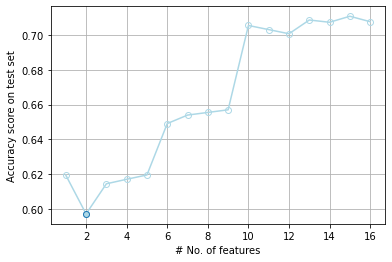

In [167]:
# Estimating accuracy score on test set using RFE by using different number of features
estimator = LogisticRegression()
acc_scores = []
for i in range(1, 17):
    selector = RFE(estimator, i)
    selector = selector.fit(X_train, y_train)
    supp = selector.get_support()

    predicted = selector.predict(X_test)
    acc_score = accuracy_score(y_test, predicted)
    acc_scores.append(acc_score)
  
best = 1
for item in acc_scores:
    if item < acc_scores[best - 1]:
        best = acc_scores.index(item) + 1

plt.grid()   
plt.xlabel('# No. of features')
plt.ylabel('Accuracy score on test set')
plt.plot(range(1, 17), acc_scores, marker = 'o', color = 'lightblue', markeredgewidth = 1 ,markeredgecolor = 'lightblue', markerfacecolor = 'None')
plt.plot(best, acc_scores[best-1], marker = 'o', markerfacecolor = 'lightblue')

Accroding to `RFE` model shows with `2` feathers in logsticRegesion model make predict is the lowest accurcy score and 
with choose `15` feathers ,which is the highest accurancy scoreon test dataset
However,since after `10` feathers selected , there is no significantly improved accurancy score on test dataset , i will say with choosing `10` feathers as predict model should be a good option

In [252]:
# with use 10 feathers in logisticRegression 
lr_model = LogisticRegression()
rfe_10 = RFE(estimator=lr_model, n_features_to_select=10, step=1)
rfe_10.fit(X_train, y_train)

RFE(estimator=LogisticRegression(), n_features_to_select=10)

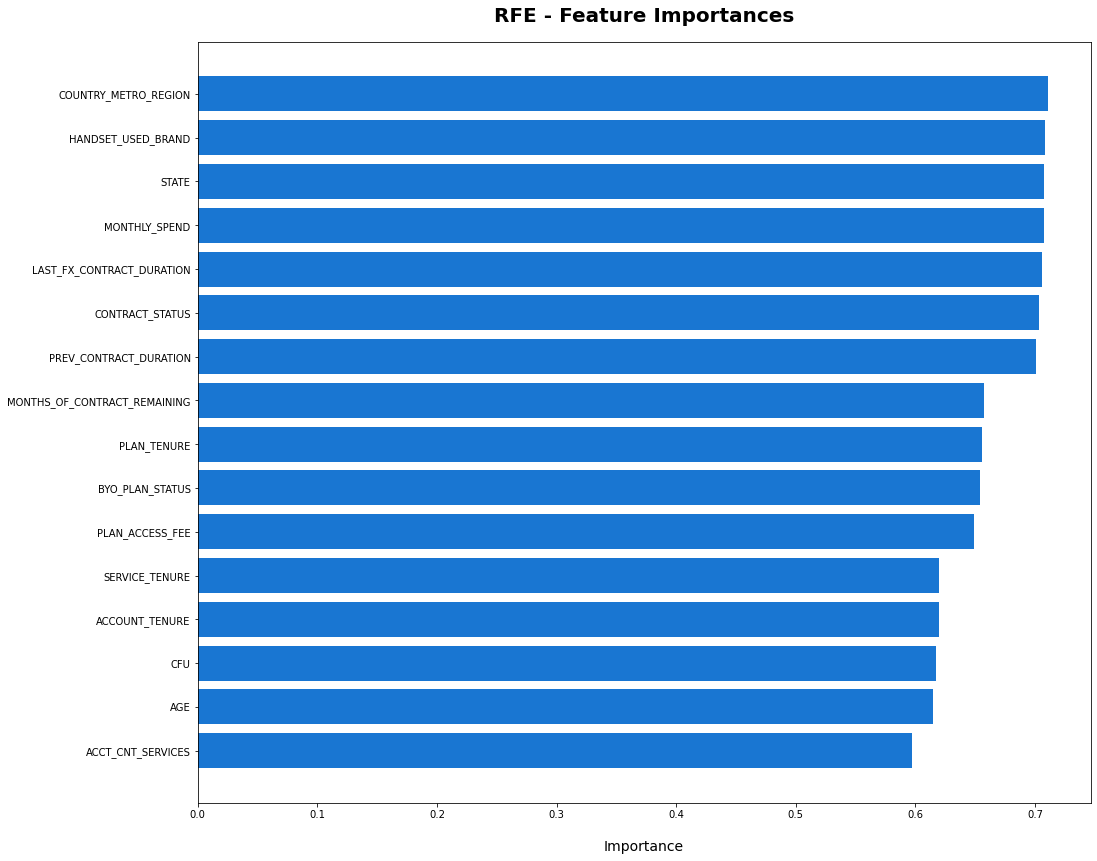

In [257]:
#use test dataset
dset = pd.DataFrame()
dset['attr'] = X_test.columns
dset['importance'] = acc_scores

dset = dset.sort_values(by='importance', ascending=True)


plt.figure(figsize=(16, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFE - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

The top 10 feathers in logistic regression predict with important considered are `COUNTRY_METREO_REGION`,`HANDSET_USED_BRAND`,`STATE`,`MONTHLY_SPEND`,
`LAST_FX_CONTRACT_DURATION`,`CONTRACT_STATUS`,`PREV_CONTRACT`,
`MONTHS_OF_CONTRACT_REMAINING``PLAN_TENURE`and`BYO_PLAN_STATUS` 

## Decision tree 

Feature: 0, Score: 0.08273
Feature: 1, Score: 0.02989
Feature: 2, Score: 0.12771
Feature: 3, Score: 0.01092
Feature: 4, Score: 0.11383
Feature: 5, Score: 0.05463
Feature: 6, Score: 0.00727
Feature: 7, Score: 0.07827
Feature: 8, Score: 0.10556
Feature: 9, Score: 0.00588
Feature: 10, Score: 0.00523
Feature: 11, Score: 0.01678
Feature: 12, Score: 0.04139
Feature: 13, Score: 0.25033
Feature: 14, Score: 0.01490
Feature: 15, Score: 0.05467


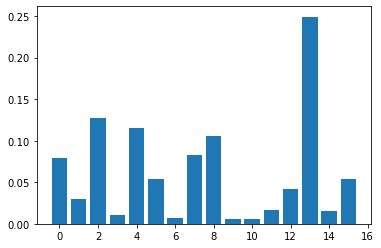

In [240]:
# decision tree for feature importance on a regression problem
from sklearn.datasets import make_regression
from matplotlib import pyplot

# define the model
model2 = DecisionTreeRegressor()
# fit the model
model2.fit(X_train,y_train )
# get importance
importance2 = model2.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance2))], importance2)
pyplot.show()

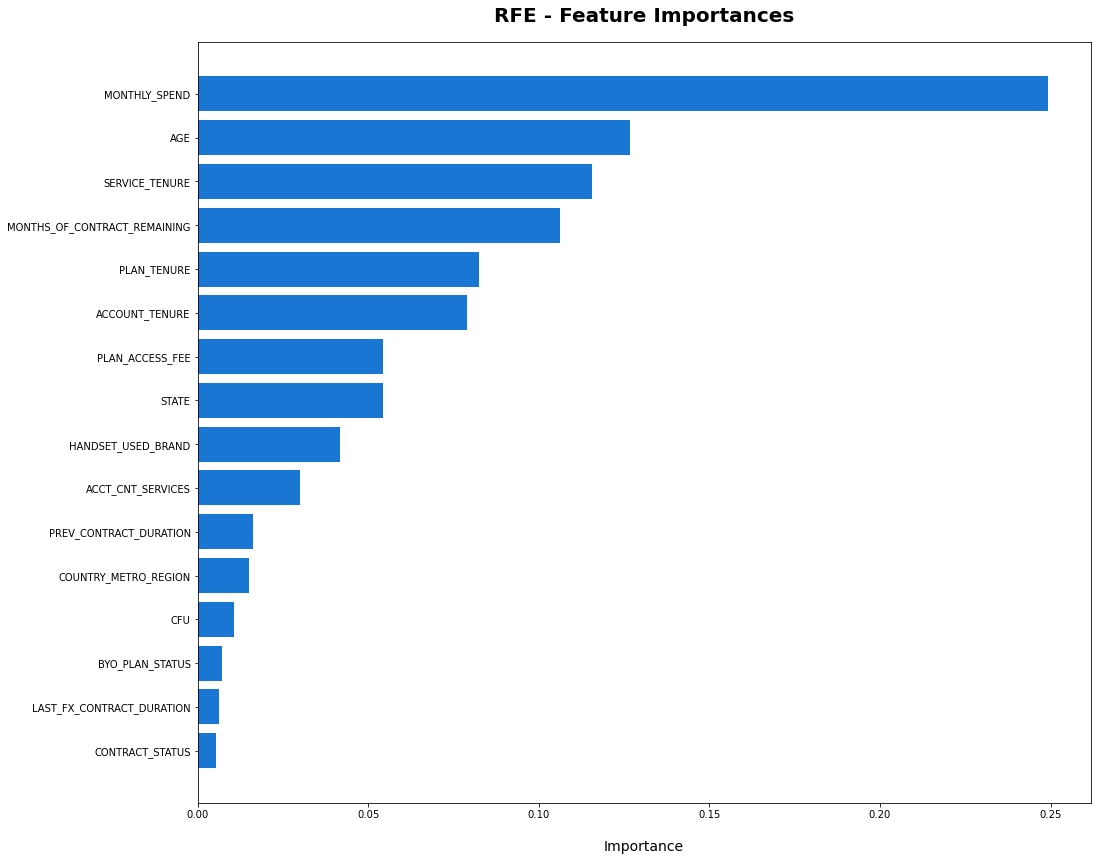

In [256]:
# use test dataset
dset = pd.DataFrame()
dset['attr'] = X_test.columns
dset['importance'] = model2.feature_importances_

dset = dset.sort_values(by='importance', ascending=True)


plt.figure(figsize=(16, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFE - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

- `Decision Tree` model we can see when select `13 feathers` as predicted has a higest score
- The top important  for customer churn is `Monthly_Spend `
- The TOP `13` feathers in descision tree model are `MONTHLY_SPEND`,`AGE`,`SERVICE_TENURE`,`MONTHS_OF_CONTRACT_REMAINING`,`PLAN_TENURE`,`ACCOUNT_TENURE`,`PLAN_ACCESS_FEE` ,`STATE`,`HANDSET_USED_BRAND`,`ACCT_CNT_SERVICES `,`PREV_CONTRACT_DURATION `,`COUNTRY_METRO_REGION`and`CFU`	
- The 3 of `lowest important` for `customer churn ` are `BYO_PLAN_STATUS`,`LAST_FX_CONTRACT_DURATION`and `CONTRACT_STATUS`

In [272]:
# Training DecisionTree classifers model
from sklearn.tree import DecisionTreeClassifier
model2=DecisionTreeClassifier()
model2.fit(X_train, y_train)

DecisionTreeClassifier()

In [273]:
# Doing predictions on train and test set
y_hat_train2 = model2.predict(X_train)
y_hat_test2 = model2.predict(X_test)

In [275]:
# Evaluate the performance of my trained model
print("Accuracy score on training set: ", accuracy_score(y_train, y_hat_train2))
print("Accuracy score on testing set: ", accuracy_score(y_test, y_hat_test2))

Accuracy score on training set:  0.9996483064603398
Accuracy score on testing set:  0.6923826011685782


- since accuracy on training set is very high and the gap between training and test is large , it is `overfiting `

In [276]:
print("Confusion matrix on train set: ")
print(confusion_matrix(y_train, y_hat_train2))

Confusion matrix on train set: 
[[22691     0]
 [   13 14260]]


In [274]:
print("Confusion matrix on test set: ")
print(confusion_matrix(y_test, y_hat_test2))

Confusion matrix on test set: 
[[4188 1537]
 [1306 2211]]


In [280]:
print('Does LogisticRegression have higher accurancy than DecisionTressClassifer model ?',accuracy_score(y_test, y_hat_test)>accuracy_score(y_test, y_hat_test2))

Does LogisticRegression have higher accurancy than DecisionTressClassifer model ? True


### In conclution i suggest to use logisticRegression model to predict customer churn compared to DecisionTree model